In [1]:
import cooltools

In [2]:
cooltools.numutils.zoom_array?

In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
import os
import cooler
import cooltools
import numpy as np
from cooltools import eigdecomp
import bioframe
from pathlib import Path
import multiprocess as mp
import pandas as pd

from copy import copy

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# import all samples as dictionary ...
from samples import *


In [4]:
# ins_samples = {
#     "Hap1-WT-combined.hg19" : "Hap1-WT-combined.mcool",
# }

ins_samples = {
    #cooler locations, some expected at these locations
    # CTCF degron
    "CkoCT442_NT_pool.hg19" : "/data/alv/CTCF_degron/data/CkoCT442-NT-pool.mcool",
    "CkoCT442_IAA_pool.hg19" : "/data/alv/CTCF_degron/data/CkoCT442-IAA-pool.mcool",

    #polII degron
    "PolII-NT.hg19" : "/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-NT.hg19.mapq_30.1000.mcool",
    "PolII-IAA.hg19" : "/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-IAA.hg19.mapq_30.1000.mcool",

    #AAVS1 clone
    "mutControl-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-NT-pool.mcool",
    "mutControl-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-IAA-pool.mcool",

    #DDX55 clones
    "mutDDX55-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-NT.hg19.mapq_30.1000.mcool",
    "mutDDX55-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-IAA.hg19.mapq_30.1000.mcool",

    #TAF5L clones
    "mutTAF5L-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-NT.hg19.mapq_30.1000.mcool",
    "mutTAF5L-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-IAA.hg19.mapq_30.1000.mcool",

    #siCONTROL
    "siControl-NT.hg19" : "/data/alv/CTCF_degron/data/siCTRL-NT.hg19.mapq_30.1000.mcool",
    "siControl-IAA.hg19" : "/data/alv/CTCF_degron/data/siCTRL-IAA.hg19.mapq_30.1000.mcool",

    #siDDX55
    "siDDX55-NT.hg19" : "/data/alv/CTCF_degron/data/siDDX55-NT.hg19.mapq_30.1000.mcool",
    "siDDX55-IAA.hg19" : "/data/alv/CTCF_degron/data/siDDX55-IAA.hg19.mapq_30.1000.mcool",

    #siTAF5L
    "siTAF5L-NT.hg19" : "/data/alv/CTCF_degron/data/siTAF5L-NT.hg19.mapq_30.1000.mcool",
    "siTAF5L-IAA.hg19" : "/data/alv/CTCF_degron/data/siTAF5L-IAA.hg19.mapq_30.1000.mcool",

    #RAD21 degron
    "RAD21-NT.hg19" : "/data/alv/CTCF_degron/data/RAD21-AID-NT.hg19.mapq_30.1000.mcool",
    "RAD21-IAA.hg19" : "/data/alv/CTCF_degron/data/RAD21-AID-IAA-6H.hg19.mapq_30.1000.mcool",

    #PlaB splicing inhibition
    "CtrlPlaB-NT.hg19" : "/data/alv/CTCF_degron/data/NT-hg19-combined-90000000.mcool",
    "CtrlPlaB-IAA.hg19" : "/data/alv/CTCF_degron/data/IAA-hg19-combined-90000000.mcool",
    "PlaB-NT.hg19" : "/data/alv/CTCF_degron/data/NT-PlaB-hg19-combined-90000000.mcool",
    "PlaB-IAA.hg19" : "/data/alv/CTCF_degron/data/IAA-PlaB-hg19-combined-90000000.mcool",

    #compare with WT
    "Ctrl500M-noTIR1.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/Hap1-WT-combined-500000000.mcool",
    "Ctrl500M-wtHAP1.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoC44-NO-TIR1-pool.mcool",
    "Ctrl500M-CT442-NT.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-NT-pool-500000000.mcool",
    "Ctrl500M-CT442-IAA.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-IAA-pool-500000000.mcool",
}

In [5]:
# ins_samples = {
#     "Hap1-WT-combined.hg19" : f"Hap1-WT-combined.mcool",
# }

binsize = 5_000
binsize_human = f"{int(binsize/1_000)}kb"


exp_samples = {
    #cooler locations, some expected at these locations
    # CTCF degron
    "CkoCT442_NT_pool.hg19" : f"/data/alv/CTCF_degron/data/CkoCT442-NT-pool.{binsize_human}.cis.exp.tsv",
    "CkoCT442_IAA_pool.hg19" : f"/data/alv/CTCF_degron/data/CkoCT442-IAA-pool.{binsize_human}.cis.exp.tsv",

    #polII degron
    "PolII-NT.hg19" : f"/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "PolII-IAA.hg19" : f"/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #AAVS1 clone
    "mutControl-NT.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-NT-pool.{binsize_human}.cis.exp.tsv",
    "mutControl-IAA.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-IAA-pool.{binsize_human}.cis.exp.tsv",

    #DDX55 clones
    "mutDDX55-NT.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "mutDDX55-IAA.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #TAF5L clones
    "mutTAF5L-NT.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "mutTAF5L-IAA.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #siCONTROL
    "siControl-NT.hg19" : f"/data/alv/CTCF_degron/data/siCTRL-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "siControl-IAA.hg19" : f"/data/alv/CTCF_degron/data/siCTRL-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #siDDX55
    "siDDX55-NT.hg19" : f"/data/alv/CTCF_degron/data/siDDX55-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "siDDX55-IAA.hg19" : f"/data/alv/CTCF_degron/data/siDDX55-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #siTAF5L
    "siTAF5L-NT.hg19" : f"/data/alv/CTCF_degron/data/siTAF5L-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "siTAF5L-IAA.hg19" : f"/data/alv/CTCF_degron/data/siTAF5L-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #RAD21 degron
    "RAD21-NT.hg19" : f"/data/alv/CTCF_degron/data/RAD21-AID-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "RAD21-IAA.hg19" : f"/data/alv/CTCF_degron/data/RAD21-AID-IAA-6H.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #PlaB splicing inhibition
    "CtrlPlaB-NT.hg19" : f"/data/alv/CTCF_degron/data/NT-hg19-combined-90000000.{binsize_human}.cis.exp.tsv",
    "CtrlPlaB-IAA.hg19" : f"/data/alv/CTCF_degron/data/IAA-hg19-combined-90000000.{binsize_human}.cis.exp.tsv",
    "PlaB-NT.hg19" : f"/data/alv/CTCF_degron/data/NT-PlaB-hg19-combined-90000000.{binsize_human}.cis.exp.tsv",
    "PlaB-IAA.hg19" : f"/data/alv/CTCF_degron/data/IAA-PlaB-hg19-combined-90000000.{binsize_human}.cis.exp.tsv",

    #compare with WT
    "Ctrl500M-noTIR1.hg19" : f"/data/alv/CTCF_degron/data/WT-44-442-pool/Hap1-WT-combined-500000000.{binsize_human}.cis.exp.tsv",
    "Ctrl500M-wtHAP1.hg19" : f"/data/alv/CTCF_degron/data/WT-44-442-pool/CkoC44-NO-TIR1-pool.{binsize_human}.cis.exp.tsv",
    "Ctrl500M-CT442-NT.hg19" : f"/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-NT-pool-500000000.{binsize_human}.cis.exp.tsv",
    "Ctrl500M-CT442-IAA.hg19" : f"/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-IAA-pool-500000000.{binsize_human}.cis.exp.tsv",
}

#### get some gene annotation the way we used it in the stackups (one from RefSeq, from HiGlass ...)

In [12]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

#### Get expression data measured in TPMs

In [13]:
# column names for the RNA-seq samples generated for various controls, mutants and siRNAs ...
rsem_si_cols = ['rsem.out.S442_IAA',
                'rsem.out.S442_IAAR2',
                'rsem.out.S442_NT',
                'rsem.out.S442_NTR2',
                'rsem.out.S442_siCTRL_IAAR2',
                'rsem.out.S442_siCTRL_NTR2',
                'rsem.out.S442_siCtrl_IAA',
                'rsem.out.S442_siCtrl_NT',
                'rsem.out.S442_siDDX55_IAA',
                'rsem.out.S442_siDDX55_IAAR2',
                'rsem.out.S442_siDDX55_NT',
                'rsem.out.S442_siDDX55_NTR2',
                'rsem.out.S442_siTAF5L_IAA',
                'rsem.out.S442_siTAF5L_IAAR2',
                'rsem.out.S442_siTAF5L_NT',
                'rsem.out.S442_siTAF5L_NTR2',
                'rsem.out.S44_IAA',
                'rsem.out.S44_IAAR2',
                'rsem.out.S44_NT',
                'rsem.out.S44_NTR2']
rsem_mut_cols = ['rsem.out.AAVS1_sg24_IAA',
                'rsem.out.AAVS1_sg24_IAAR2',
                'rsem.out.AAVS1_sg24_NT',
                'rsem.out.AAVS1_sg24_NTR2',
                'rsem.out.DDX55_sg27_IAA',
                'rsem.out.DDX55_sg27_IAAR2',
                'rsem.out.DDX55_sg27_NT',
                'rsem.out.DDX55_sg27_NTR2',
                'rsem.out.DDX55_sg2B_IAA',
                'rsem.out.DDX55_sg2B_IAAR2',
                'rsem.out.DDX55_sg2B_NT',
                'rsem.out.DDX55_sg2B_NTR2',
                'rsem.out.TAF5L_sg23_IAA',
                'rsem.out.TAF5L_sg23_IAAR2',
                'rsem.out.TAF5L_sg23_NT',
                'rsem.out.TAF5L_sg23_NTR2',
                'rsem.out.TAF5L_sg27_IAA',
                'rsem.out.TAF5L_sg27_IAAR2',
                'rsem.out.TAF5L_sg27_NT',
                'rsem.out.TAF5L_sg27_NTR2']

In [15]:
rsem_si_df = pd.read_csv("merged_TPM_genes_si.tsv",sep="\t")[["Id"] + rsem_si_cols]
rsem_mut_df = pd.read_csv("merged_TPM_genes_mut.tsv",sep="\t")[["Id"] + rsem_mut_cols]

# merge si and mut parts to create a monster RNA-seq data set ...
rsem_df = pd.merge(rsem_si_df,rsem_mut_df,how="inner",on="Id")

# some checks
assert np.asarray([(c in rsem_df.columns) for c in rsem_mut_cols]).all()
assert np.asarray([(c in rsem_df.columns) for c in rsem_si_cols]).all()
assert len(rsem_df) == len(rsem_si_df) == len(rsem_mut_df)


#### We'll be using minimum and maximum levels of RNA-seq per gene across samples to define our lists of "commonly" active and inactive genes - so let's calculate min/max and drop all other columns ...

Text(0, 0.5, 'min-TPM')

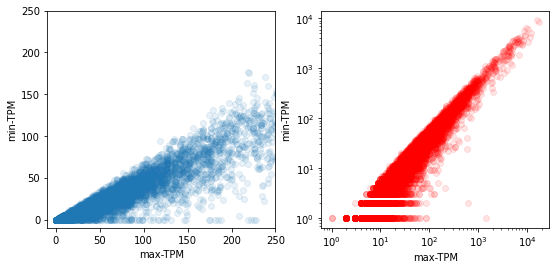

In [16]:
# explore a bit how min vs max behave ...
# are there a lot of genes that go from expressed to not expressed etc ...
_max_col = rsem_df[ rsem_si_cols+rsem_mut_cols ].max(axis=1)
_min_col = rsem_df[ rsem_si_cols+rsem_mut_cols ].min(axis=1)

x = _max_col
y = _min_col

f,axs = plt.subplots(1,2,figsize=(9,4))
ax = axs[0]
ax.scatter(x,y,alpha=0.1)
ax.set_xlabel("max-TPM")
ax.set_ylabel("min-TPM")
ax.set_xlim((-10,250))
ax.set_ylim((-10,250))
ax = axs[1]
ax.loglog(x,y,"ro",alpha=0.1)
ax.set_xlabel("max-TPM")
ax.set_ylabel("min-TPM")

In [17]:
rsem_df = rsem_df[["Id"]]
rsem_df["exp_min"] = _min_col
rsem_df["exp_max"] = _max_col

#### Overlap that refined dataframe of RNA-seq results with "our" list of genes ...

In [19]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
genes_exp_df.head(3)
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

,Id,exp_min,exp_max,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4273,7092,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,12,21,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [20]:
# refine the dataframe  ...
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "exp_min", "exp_max"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end"}

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [21]:
# final adjustments ...
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

,chrom,start,end,strand,exp_min,exp_max,size
0,chr1,11873,14409,+,0,0,2536
1,chr1,14361,29370,-,28,56,15009
2,chr1,69090,70008,+,0,0,918


In [22]:
all_genes = copy(gdf)

In [23]:
all_genes

,chrom,start,end,strand,exp_min,exp_max,size
0,chr1,11873,14409,+,0,0,2536
1,chr1,14361,29370,-,28,56,15009
2,chr1,69090,70008,+,0,0,918
3,chr1,134772,140566,-,0,0,5794
4,chr1,562759,564389,-,0,0,1630
...,...,...,...,...,...,...,...
22289,chr9,140732870,140732968,+,0,0,98
22290,chr9,140762376,140787022,-,0,0,24646
22291,chr9,140772233,141019069,+,0,0,246836
22292,chr9,140934954,140939523,-,0,0,4569


## Deal with gene-CTCF relationships ...
### Deal with CTCF either in the body of the gene or @TSS/TTS ...

### Let's exclude genes that have CTCF within 2kb of TSS ...

In [26]:
from copy import copy
ctcf_df = bioframe.read_table(
        "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed",
        schema="bed3",
        index_col=False
)

ctcf_radius = 2_000
_tss = copy(all_genes)
_tss["tss"] = _tss.apply(lambda r: r["start"] if r["strand"]=="+" else r["end"],axis=1)
_tss["tss_mflank"] = _tss["tss"] - ctcf_radius
_tss["tss_pflank"] = _tss["tss"] + ctcf_radius
# _tss[["chrom","tss_mflank","tss_pflank"]]

tss_ctcf_overlap = bioframe.overlap(
    _tss[["chrom","tss_mflank","tss_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tss_mflank","tss_pflank"],
)


_tts = copy(all_genes)
_tts["tts"] = _tts.apply(lambda r: r["end"] if r["strand"]=="+" else r["start"],axis=1)
_tts["tts_mflank"] = _tts["tts"] - ctcf_radius
_tts["tts_pflank"] = _tts["tts"] + ctcf_radius
# _tts[["chrom","tss_mflank","tss_pflank"]]

tts_ctcf_overlap = bioframe.overlap(
    _tts[["chrom","tts_mflank","tts_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tts_mflank","tts_pflank"],
)


#### Now let's actually exclude genes with CTCF near TSS/TTS from downstream analysis ...

In [27]:
ctcf_index = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TSS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

5063 genes have CTCF@TSS,
    17231 genes do not -
    total # of genes 22294


<ipython-input-27-bc1c4dc09ff1>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctcf_index = np.unique(ctcf_index.astype(np.int).values)
<ipython-input-27-bc1c4dc09ff1>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecate

#### same for TTS ...

In [28]:
ctcf_index = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TTS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

2568 genes have CTCF@TTS,
    19726 genes do not -
    total # of genes 22294


<ipython-input-28-f1cfe83891fd>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctcf_index = np.unique(ctcf_index.astype(np.int).values)
<ipython-input-28-f1cfe83891fd>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecate

#### combine TSS and TTS - without CTCF

In [29]:
ctcf_index_tts = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index_tts = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TTS
ctcf_index_tts = np.unique(ctcf_index_tts.astype(np.int).values)
noctcf_index_tts = np.unique(noctcf_index_tts.astype(np.int).values)


ctcf_index_tss = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index_tss = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TSS
ctcf_index_tss = np.unique(ctcf_index_tss.astype(np.int).values)
noctcf_index_tss = np.unique(noctcf_index_tss.astype(np.int).values)

# here is the strictest set - no CTCF at TSS AND TTS ...
strict_index = np.intersect1d(
                        noctcf_index_tts,
                        noctcf_index_tss
                )

all_genes_noctcf_atall = all_genes.loc[ strict_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_noctcf_atall)} genes have no CTCF@TTS and no CTCF@TSS"""
)

15710 genes have no CTCF@TTS and no CTCF@TSS


<ipython-input-29-ad407706de77>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctcf_index_tts = np.unique(ctcf_index_tts.astype(np.int).values)
<ipython-input-29-ad407706de77>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
D

### Use `gdf` variable to choose which DataFrame with genes we are going to work on  ....

In [30]:
gdf = copy(all_genes_noctcf_atall)

### explore gene size and expression levels ...

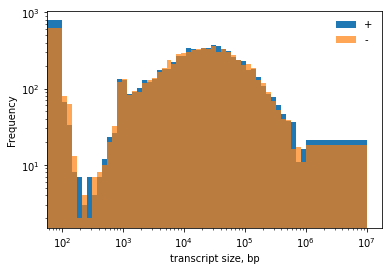

In [31]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

Text(0.5, 1.0, 'max')

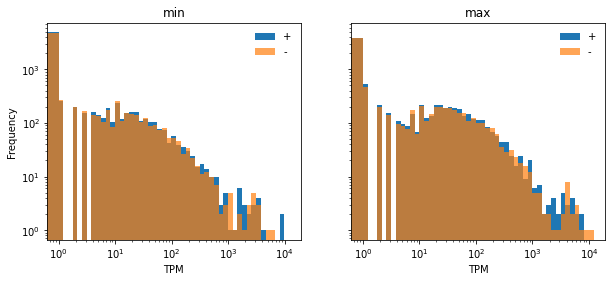

In [32]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
f,axs = plt.subplots(1,2,figsize=(10,4),sharey=True)

ax = axs[0]
gdf[gdf["strand"]=="+"]["exp_min"].plot.hist(bins=bins,log=True,label="+",ax=ax)
gdf[gdf["strand"]=="-"]["exp_min"].plot.hist(bins=bins,log=True,alpha=0.7,label="-",ax=ax)
ax.set_xscale("log")
ax.set_xlabel("TPM")
ax.legend(frameon=False)
ax.set_title("min")
ax = axs[1]
gdf[gdf["strand"]=="+"]["exp_max"].plot.hist(bins=bins,log=True,label="+",ax=ax)
gdf[gdf["strand"]=="-"]["exp_max"].plot.hist(bins=bins,log=True,alpha=0.7,label="-",ax=ax)
ax.set_xscale("log")
ax.set_xlabel("TPM")
ax.legend(frameon=False)
ax.set_title("max")

#### Classify genes into discrete categories by gene-size and expression-level ...

In [38]:
exp_bin_edges = [0,.5,5,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp_min"] = pd.cut(
    gdf["exp_min"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gexp_max"] = pd.cut(
    gdf["exp_max"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head(2))
display( gdf.groupby(["gexp_min","gsize"]).size().unstack(fill_value=0) )
# finding the common active genes and common inactive ones ...
display( gdf.groupby(["gexp_min","gexp_max","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp_min,exp_max,size,gexp_min,gexp_max,gsize
0,chr1,14361,29370,-,28,56,15009,high,high,short
1,chr1,69090,70008,+,0,0,918,no,no,short


gsize,short,long
gexp_min,,
no,7766,1915
low,1065,747
high,2875,1342


gsize              short  long
gexp_min gexp_max             
no       no         6319  1360
         low        1261   489
         high        186    66
low      no            0     0
         low         187   146
         high        878   601
high     no            0     0
         low           0     0
         high       2875  1342

In [39]:
# exp_bin_edges = [0,.5,10,np.inf]
# exp_labels = ("no","low","high")
# sizes_bin_edges = [0,50_000,np.inf]
# sizes_labels = ("short","long")

# gdf["gexp"] = pd.cut(
#     gdf["exp"],
#     bins = exp_bin_edges,
#     labels = exp_labels,
#     include_lowest = True
# )
# gdf["gsize"] = pd.cut(
#     gdf["size"],
#     bins = sizes_bin_edges,
#     labels = sizes_labels,
#     include_lowest = True
# )
# display(gdf.head())
# display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

### Let's use coolpup as Python API ...

In [40]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

#### we'll use regions to make use of "proper" expected ...

In [41]:
# Use bioframe to fetch the genomic features from the UCSC.
hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg19_chromsizes = hg19_chromsizes.set_index("chrom").loc[autosomal_chroms].reset_index() 
hg19_arms = hg19_arms.set_index("chrom").loc[autosomal_chroms].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.from_any(hg19_arms)
hg19_arms["name"] = [f"{chrom}{arm}" for chrom in autosomal_chroms for arm in list('pq')]

In [42]:
# import standard python libraries
import seaborn as sns
# import libraries for biological data analysis
import coolpuppy as cp
import cooler
import bioframe
# import cooltools
# import cooltools.expected
# from cooltools.lib import plotting

In [43]:
# ooe - Explanations and reminder ...
# (default)False: (o1 +o2 +o3 ... oN)/(e1+e2+e3+...eN) [shifting-normalization gose according to this scenraio as well]
# True: o1/e1 +o2/e2 +o3/e3 ... oN/eN

In [45]:
def get_pup(sites, clr, resolution, exp_df, regions_df):
    """
    generate scaled local pile-up for a collection of sites for a given
    cooler (clr) at a given resolution - keeping the padding size equal
    to the interval itself.
    """
    _sites = sites[["chrom","start","end","strand"]].reset_index(drop=True)
    if (len(_sites)>2_000)or(len(_sites)<1_000):
        return None
    else:
        cc = cp.CoordCreator(
            _sites,
            resolution=resolution,
            basetype='bed',
            local=True,
            fraction_pad=1.
        )
        pu = cp.PileUpper(
            clr,
            cc,
            control = True,
            rescale = True,
            rescale_size = 199,
        )
        #     pu = cp.PileUpper(
        #         clr,
        #         cc,
        #         regions= regions_df,
        #         expected = exp_df,
        #         ooe = True,
        #         control = False,
        #         rescale = True,
        #         rescale_size = 199,
        #     )
        print(f"working on a group of {len(_sites)} size ...")
        pup = pu.pileupsByStrandWithControl(nproc=18)
        return pup


In [48]:
# key_samples = ["Ctrl500M-CT442-NT.hg19"]#, "Ctrl500M-CT442-IAA.hg19"]

key_samples = ["CkoCT442_NT_pool.hg19",
                "CkoCT442_IAA_pool.hg19",
                "PolII-NT.hg19",
                "PolII-IAA.hg19",
                "mutControl-NT.hg19",
                "mutControl-IAA.hg19",
                "mutDDX55-NT.hg19",
                "mutDDX55-IAA.hg19",
                "mutTAF5L-NT.hg19",
                "mutTAF5L-IAA.hg19",
                "siControl-NT.hg19",
                "siControl-IAA.hg19",
                "siDDX55-NT.hg19",
                "siDDX55-IAA.hg19",
                "siTAF5L-NT.hg19",
                "siTAF5L-IAA.hg19",
                "RAD21-NT.hg19",
                "RAD21-IAA.hg19",
                "CtrlPlaB-NT.hg19",
                "CtrlPlaB-IAA.hg19",
                "PlaB-NT.hg19",
                "PlaB-IAA.hg19",
                "Ctrl500M-noTIR1.hg19",
                "Ctrl500M-wtHAP1.hg19",
                "Ctrl500M-CT442-NT.hg19",
                "Ctrl500M-CT442-IAA.hg19"]

pup_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp_min","gexp_max","gsize"]) #"gexp_min","gexp_max","gsize" or "gexp","gsize"
for sample in key_samples:
    print(f"working on {sample} ...")
    cname = ins_samples[sample]
    exp_name = exp_samples[sample]
    clr = cooler.Cooler(f"{cname}::/resolutions/{binsize}")
    exp_df = pd.read_csv(exp_name, sep="\t")
    pup_dict[sample] = gene_groups.apply( lambda sub_df: get_pup(sub_df, clr, binsize, exp_df, hg19_arms) )

working on CkoCT442_NT_pool.hg19 ...
working on a group of 1360 size ...
working on a group of 1261 size ...
working on a group of 1342 size ...
working on CkoCT442_IAA_pool.hg19 ...
working on a group of 1360 size ...
working on a group of 1261 size ...
working on a group of 1342 size ...
working on PolII-NT.hg19 ...
working on a group of 1360 size ...
working on a group of 1261 size ...
working on a group of 1342 size ...
working on PolII-IAA.hg19 ...
working on a group of 1360 size ...
working on a group of 1261 size ...
working on a group of 1342 size ...
working on mutControl-NT.hg19 ...
working on a group of 1360 size ...
working on a group of 1261 size ...
working on a group of 1342 size ...
working on mutControl-IAA.hg19 ...
working on a group of 1360 size ...
working on a group of 1261 size ...
working on a group of 1342 size ...
working on mutDDX55-NT.hg19 ...
working on a group of 1360 size ...
working on a group of 1261 size ...
working on a group of 1342 size ...
working o

#### Save all of the results on disk using pickle - to avoid re-running it again

In [49]:
import pickle
file_to_store = open("PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups_COMMON_expression.pickle", "wb")
# file_to_store = open("PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups.pickle", "wb")
pickle.dump(pup_dict, file_to_store)
# Save object to file
file_to_store.close()

In [50]:
# ! readlink -f PUP_DICT_5kb_SHIFT_EXP.pickle

### plotting different pileups for different groups ...

In [62]:
from matplotlib import colors

In [74]:
# glens=("short","long")
# gexps=("no","low","high")


# fig = plt.figure(figsize=(12,8),constrained_layout=True)
# gs = fig.add_gridspec(len(glens),len(gexps))
# orient="--"

# _yyyy = pup_dict["CkoCT442_IAA_pool.hg19"].reset_index().set_index(["gexp_min","gexp_max","gsize","orientation"])
# # # divnorm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25)

# for i,glen in enumerate(glens):
#     for j,gexp in enumerate(gexps):
#         ax = fig.add_subplot(gs[i,j])
#         pup_heatmap = _yyyy.loc[(gexp,gexp,glen,orient),"data"]
#         img = ax.imshow(
#             pup_heatmap,
# #             norm = MidPointLogNorm(vmin=0.4,vmax=1.1,midpoint=1),
#             norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25),
#             cmap="coolwarm",
#             interpolation="nearest",            
#         )
#         ax.set_title(f"{gexp}-{glen}-{orient}") 
# plt.colorbar(img)

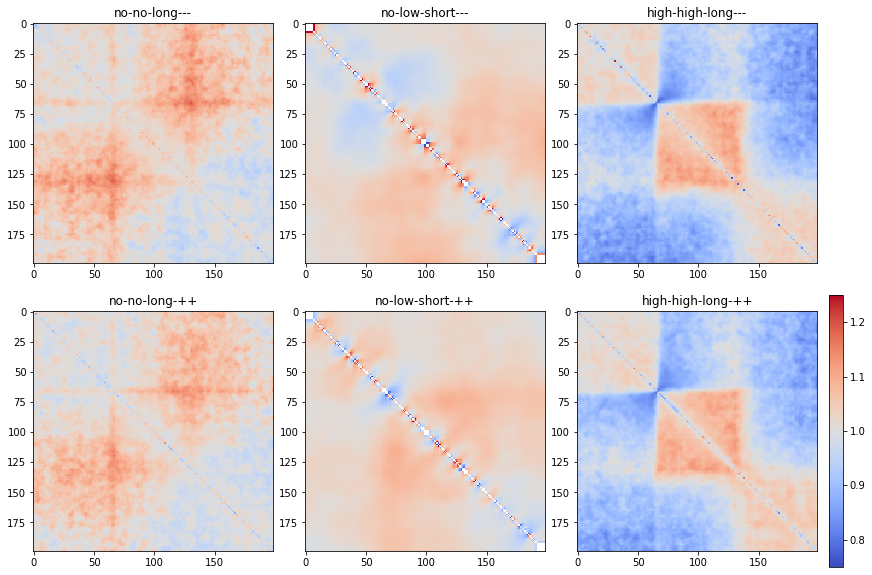

In [73]:
####
# grouped using gxp_moin and gexp_max ...
####
_yyyy = pup_dict["CkoCT442_NT_pool.hg19"].reset_index().set_index(["gexp_min","gexp_max","gsize","orientation"])
# # divnorm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25)

# glens=("short","long")
# gexps=("no","low","high")


fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec( 2, int(len(_yyyy.index)/2) )
# orient="--"

the_norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25)

for i,(gmi,gma,glen,orient) in enumerate(_yyyy.index[::2]):
#     print(gmi,gma,glen)
    ax = fig.add_subplot(gs[0,i])
    pup_heatmap = _yyyy.loc[(gmi,gma,glen,"--"),"data"]
    img = ax.imshow(
        pup_heatmap[::-1,::-1],
        norm = the_norm,
        cmap="coolwarm",
        interpolation="nearest",            
    )
    ax.set_title(f"{gmi}-{gma}-{glen}---") 
    #     print(gmi,gma,glen)
    ax = fig.add_subplot(gs[1,i])
    pup_heatmap = _yyyy.loc[(gmi,gma,glen,"++"),"data"]
    img = ax.imshow(
        pup_heatmap,
        norm = the_norm,
        cmap="coolwarm",
        interpolation="nearest",            
    )
    ax.set_title(f"{gmi}-{gma}-{glen}-++") 
plt.colorbar(img)